<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/paper_supplement/PrimerTutorial%205%20-%20Functional%20variant%20characterization%20for%20non-coding%20SNPs%20within%20the%20SPI1%20motif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train your DragoNN tutorial 5: 
## Functional variant characterization for non-coding SNPs within the SPI1 motif 

This tutorial is a supplement to the DragoNN manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data: SPI1 ChiP-seq and experimental bQTL data</a></li>
    <li><a href=#2>Genomewide classification and regression labels for SPI1 TF ChiPseq</a></li>
    <li><a href=#3>Optional: Download pre-generated models and test-set predictions</a></li>
    <li><a href=#4>Genome-wide classification for SPI1</a></li>
    <li><a href=#5>Genome-wide regression for SPI1</a></li> 
    <li><a href=#6>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT</a></li>
    <li><a href=#7>Recovering bQTL effect sizes: Classification vs Regression</a></li>
    <li><a href=#8>Model-predicted SNP effect sizes vs bQTL effect sizes</a></li>
    <li><a href=#a>Kat's architecture: Classification Model</a></li>
    <li><a href=#b>Kat's architecture: Regression Model</a></li> 
    <li><a href=#9>Conclusions</a></li>    
    <li><a href=#10>Save tutorial outputs</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [0]:
# If you don't have bedtools installed in your environment (i.e. Google Colab), uncomment and run the command below 
#!apt-get install bedtools
#!pip install pybedtools

In [0]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.2

In [0]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [0]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

## Input data <a name='1'>
<a href=#outline>Home</a>

This tutorial uses the same in vivo SPI1 transcription factor CHiP-seq dataset that was used in [Tutorial 4](https://colab.research.google.com/github/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/PrimerTutorial%204%20-%20Interpreting%20predictive%20sequence%20features%20in%20in-vivo%20TF%20binding%20events.ipynb). Our goal is to compare predicted variant effect sizes from classification and regression models against experimental bQTL data. The bQTL data in this way serves as a "gold-standard" validation that in silico mutagenesis on the deep learning inputs leads to correct variant effect size prediction.  We  will use bQTL data  that has been intersected with SPI1 CISBP genome motif annotations. 

In [0]:
# SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

#Fold change bigWig track for the SPI1 dataset: 
!wget -O SPI1.pooled.fc.bigWig http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-macs2_pooled/execution/ENCFF000OBU.Rep1.merged.nodup.pooled_x_ENCFF000OCW.Control.Rep1.merged.nodup.fc.signal.bigwig
    
## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi 

    




--2019-02-18 03:01:45--  http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3529 (3.4K) [application/x-gzip]
Saving to: ‘hg19.genome.fa.gz.fai.1’

hg19.genome.fa.gz.f 100%[===================>]   3.45K  --.-KB/s    in 0s      

2019-02-18 03:01:46 (241 MB/s) - ‘hg19.genome.fa.gz.fai.1’ saved [3529/3529]

--2019-02-18 03:01:47--  http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784296 (766K) [application/x-gzip]
Saving to: ‘hg19.genome.fa.gz.gzi.1’

hg19.genome.fa.gz.g 100%[===================>] 765.91K  3.54MB/s    in 0.2s    

2019

In [0]:
# Download bQTL experimental data for SPI1 loci 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

--2019-02-18 02:08:06--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23850031 (23M) [application/x-gzip]
Saving to: ‘SPI1.bQTLs.txt.gz’

SPI1.bQTLs.txt.gz   100%[===================>]  22.75M  23.3MB/s    in 1.0s    

2019-02-18 02:08:07 (23.3 MB/s) - ‘SPI1.bQTLs.txt.gz’ saved [23850031/23850031]



## Generating genome-wide classification and regression labels <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [0]:
from seqdataloader import * 

In [0]:
## seqdataloader accepts an input file, which we call SPI1.tasks.tsv, with task names in column 1, corresponding
## peak files in column 2, and the signal track in column 3. In this tutorial, the task file will have a single task entry for the SPI1 TF CHiP-seq
with open("SPI1.task.tsv",'w') as f: 
    f.write("SPI1\tSPI1.narrowPeak.gz\tSPI1.pooled.fc.bigWig\n")
f.close() 
!cat SPI1.task.tsv

SPI1	SPI1.narrowPeak.gz	SPI1.pooled.fc.bigWig


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* In the classification case, each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. The bin is labeled negative if there is no overlap with the narrowPeak. 
* In the regression case, the asinh(mean coverage) in the 200 bp bin is computed. 


**Note**: The label generation may take 10 - 15 minutes to complete. If you prefer not to wait, you can download the 
pre-generated classification and regression labels for the training, validation, and test sets by uncommenting the code below: 

In [0]:
## Classification labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.classification.hdf5

## Regression labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5


--2019-02-18 02:12:14--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.hdf5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1998551405 (1.9G)
Saving to: ‘SPI1.train.classification.hdf5’

SPI1.train.classifi 100%[===================>]   1.86G  29.8MB/s    in 75s     

2019-02-18 02:13:30 (25.3 MB/s) - ‘SPI1.train.classification.hdf5’ saved [1998551405/1998551405]

--2019-02-18 02:13:30--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.hdf5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186498977 (178M)
Saving to: ‘SPI1.valid.classification.hdf5’

SPI1.valid.classifi 100%[===================>] 177.86M  26.4MB/s  

If you prefer to generate the labels from scratch, execute the two code cell below: 

In [0]:
#  Generate genome-wide classification labels 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set. Also, the dataset does not
# include chromosome Y, so we exclude it as well. 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)


In [0]:
# Generate regression labels genome-wide 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(test_set_params)


Let's examine the files that were generated: 

In [0]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("SPI1.train.classification.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END           
chr3 50000000 50001000   0.0
     50000050 50001050   0.0
     50000100 50001100   0.0
     50000150 50001150   0.0
     50000200 50001200   0.0
     50000250 50001250   0.0
     50000300 50001300   0.0
     50000350 50001350   0.0
     50000400 50001400   0.0
     50000450 50001450   0.0

In [0]:
pd.read_hdf("SPI1.train.regression.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END               
chr3 50000000 50001000  0.287037
     50000050 50001050  0.436855
     50000100 50001100  0.491599
     50000150 50001150  0.460063
     50000200 50001200  0.460063
     50000250 50001250  0.460063
     50000300 50001300  0.491599
     50000350 50001350  0.519880
     50000400 50001400  0.633077
     50000450 50001450  0.709212

## Optional: Download pre-generated models and test-set predictions <a name='3'>
<a href=#outline>Home</a>

Next, we will train classification and regression models to predict TF CHiP-seq peaks for SPI1. If you want to skip straight to model interpretation and bQTL analysis, you can download the pre-trained models by uncommenting the 
block of code below. 

In [0]:
from keras.models import load_model 

## Download classification model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
spi1_classification_model=load_model("SPI1.classification.model.hdf5")

## Download regression model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
spi1_regression_model=load_model("SPI1.regression.model.hdf5")


## Get test set classification model and regression model predictions 
import h5py
test_set_predictions=h5py.File("SPI1.test.predictions.hdf5")
spi1_test_classification_predictions=test_set_predictions['classification'].value 
spi1_test_regression_predictions=test_set_predictions['regression'].value 

## Genome-wide classification model <a name='4'>
<a href=#outline>Home</a>


In [0]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [0]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
def initialize_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

We create generators for the training and validation data: 

In [0]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)


Using TensorFlow backend.


In [0]:
#Train the SPI1 classification model 
spi1_classification_model=initialize_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_classification=spi1_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

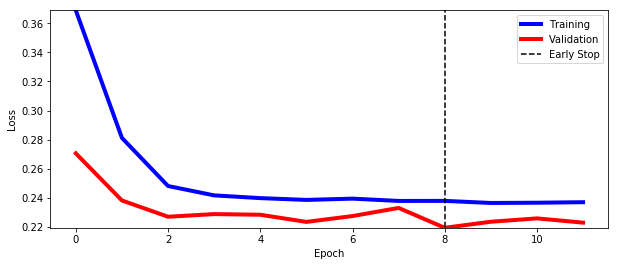

In [0]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_classification)

We now measure how well the model performed by calculating performance metrics on the test splits across the whole genome. 

In [0]:
from dragonn.generators import * 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_classification_predictions=spi1_classification_model.predict_generator(spi1_test_classification_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_classification_truth=spi1_test_classification_gen.data

6047/6047 [==============================] - 316s 52ms/step


In [0]:
spi1_test_classification_predictions.shape

(6046528, 1)

In [0]:
spi1_test_classification_truth.shape

(6046528, 1)

In [0]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_truth.values.astype(bool),spi1_test_classification_predictions))

Loss: 0.1484	Balanced Accuracy: 89.47%	 auROC: 0.968	 auPRC: 0.201
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 20639	 Num Negatives: 6025889


In [0]:
#save the models 
spi1_classification_model.save("SPI1.classification.model.hdf5")

## Genome-wide regression model <a name='5'>
<a href=#outline>Home</a>

In [0]:
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=10,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=5,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(ntasks))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

(4010730, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8900d1320>]],
      dtype=object)

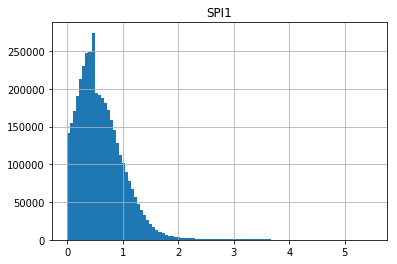

In [0]:
#we want to determine a threshold for upsampling the non-zero bins in a given batch 
# extract 5 million datapoints from the training data and observe the distribution of non-zero signal values  
sample=pd.read_hdf("SPI1.train.regression.hdf5",start=0,stop=5000000)
nonzero_sample=sample[sample.max(axis=1)>0]
print(nonzero_sample.shape)
nonzero_sample.hist(bins=100)

This suggests that 0.1 is a reasonable threshold for upsampling signal bins in regression 

In [0]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.01)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.01)


In [0]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 155s 15ms/step - loss: 0.1167 - val_loss: 0.1164
Epoch 2/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1112 - val_loss: 0.1112
Epoch 3/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1094 - val_loss: 0.1109
Epoch 4/150
10000/10000 [==============================] - 129s 13ms/step - loss: 0.1085 - val_loss: 0.1118
Epoch 5/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1079 - val_loss: 0.1098
Epoch 6/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1071 - val_loss: 0.1101
Epoch 7/150
10000/10000 [==============================] - 129s 13ms/step - loss: 0.1063 - val_loss: 0.1093
Epoch 8/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1068 - val_loss: 0.1088
Epoch 9/150
10000/10000 [==============================] - 130s 13ms/step - loss: 0.1063 - val_loss: 0.1103
Epoch 10/150
10000/10000 [==

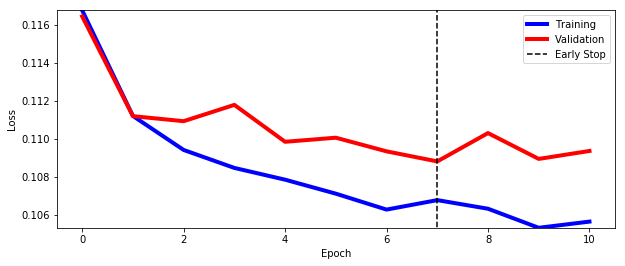

In [0]:
plot_learning_curve(history_regression)

In [0]:
from dragonn.generators import * 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 331s 55ms/step


In [0]:
## find the indices of the non-zero coverage bins 
nonzero_bins=spi1_test_regression_truth.max(axis=1)>0

In [0]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.48666784], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.5009449436825775, pvalue=0.0)


In [0]:
# Calculate the spearman and pearson correlation, restricted to non-zero bins 
corr_pearson_nonzero_bins=pearsonr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
corr_spearman_nonzero_bins=spearmanr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
print("Pearson correlation on test set:"+str(corr_pearson_nonzero_bins))
print("Spearman correlation on test set:"+str(corr_spearman_nonzero_bins))

Pearson correlation on test set:(array([0.4036342], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.3919452116707963, pvalue=0.0)


In [0]:
#There is some overfitting, let's save this model and see if we can do better 
spi1_regression_model.save("SPI1.regression.model.hdf5")

In [0]:
spi1_test_regression_truth.values[0:10].squeeze()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
test_df=pd.DataFrame({"Observed":list(spi1_test_regression_truth.values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions.squeeze())})

In [0]:
test_df_nonzero=pd.DataFrame({"Observed":list(spi1_test_regression_truth[nonzero_bins].values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions[nonzero_bins].squeeze())})

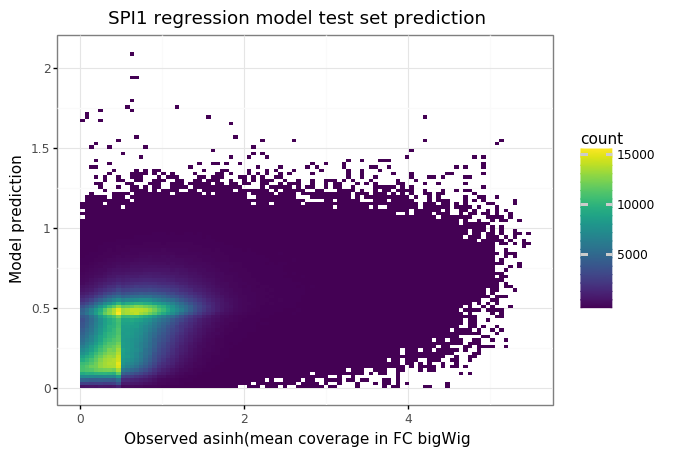

<ggplot: (-9223363282094948285)>


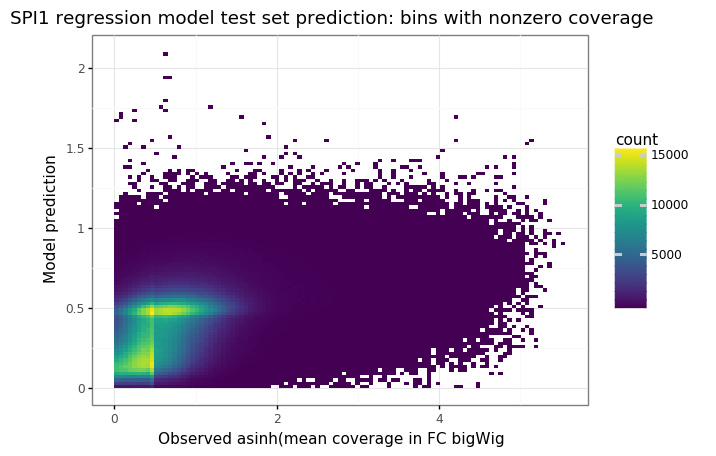

<ggplot: (-9223363282062979689)>


In [0]:
import plotnine 
from plotnine import * 
print((ggplot(test_df,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction")))

print((ggplot(test_df_nonzero,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction: bins with nonzero coverage")))

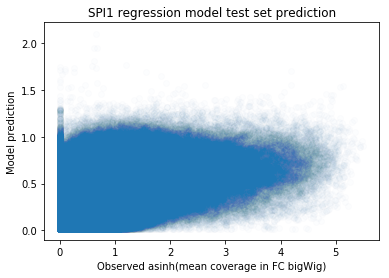

In [0]:
# Plot observed vs predicted regression values 
plt.scatter(spi1_test_regression_truth, spi1_test_regression_predictions, alpha=0.01)
plt.xlabel("Observed asinh(mean coverage in FC bigWig)")
plt.ylabel("Model prediction")
plt.title("SPI1 regression model test set prediction")
plt.show()

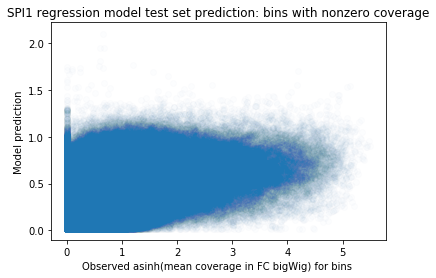

In [0]:
# Plot observed vs predicted regression values for the nonzero bins 
plt.scatter(spi1_test_regression_truth, spi1_test_regression_predictions, alpha=0.01)
plt.xlabel("Observed asinh(mean coverage in FC bigWig) for bins ")
plt.ylabel("Model prediction")
plt.title("SPI1 regression model test set prediction: bins with nonzero coverage")
plt.show()

## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='6'>
<a href=#outline>Home</a>

### Classification Model

In [0]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
spi1_test_classification_truth_bool=spi1_test_classification_truth.values.astype(bool)
true_pos_spi1=spi1_test_classification_truth[spi1_test_classification_truth_bool*spi1_test_classification_predictions >0.9]
true_pos_spi1.head

In [0]:
true_pos_spi1.shape

(6836, 1)

In [0]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

(6836, 1, 1000, 4)

In [0]:
from dragonn.tutorial_utils import deeplift 

In [0]:
deep_lift_scores_spi1=deeplift(spi1_classification_model,deep_lift_input_spi1)

In [0]:
deep_lift_scores_spi1.shape

(6836, 1, 1000, 4)

Let's plot a few of the DeepLIFT tracks and see if the model successfully learned SPI1:

In [0]:
from dragonn.tutorial_utils import  plot_seq_importance

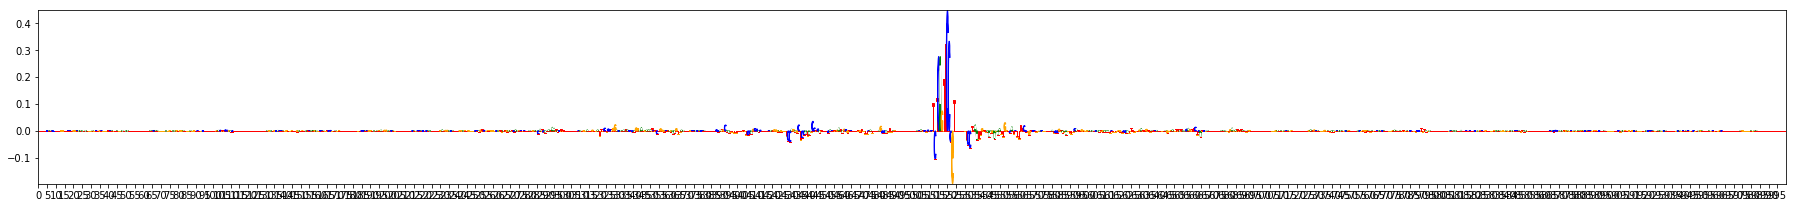

In [0]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

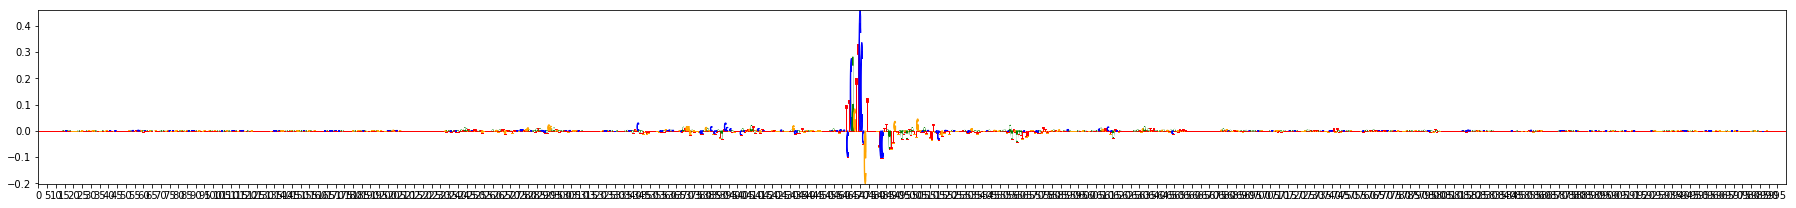

In [0]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

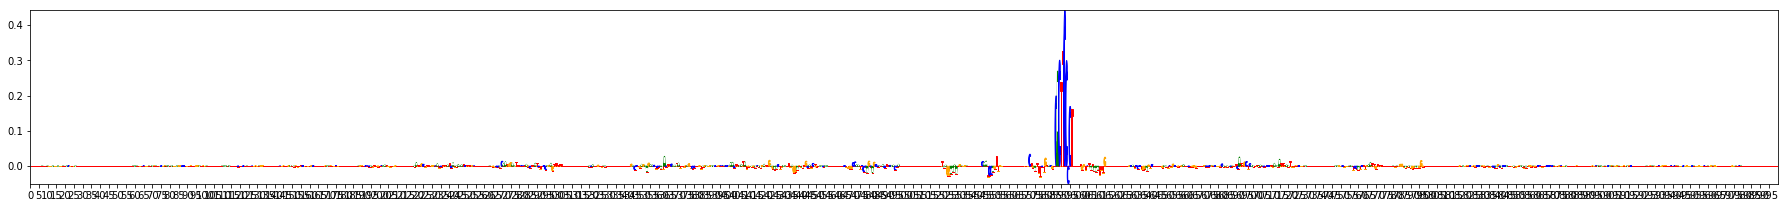

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

Let's zoom in to the center of one sequence so that it is easier to distinguish the motif: 

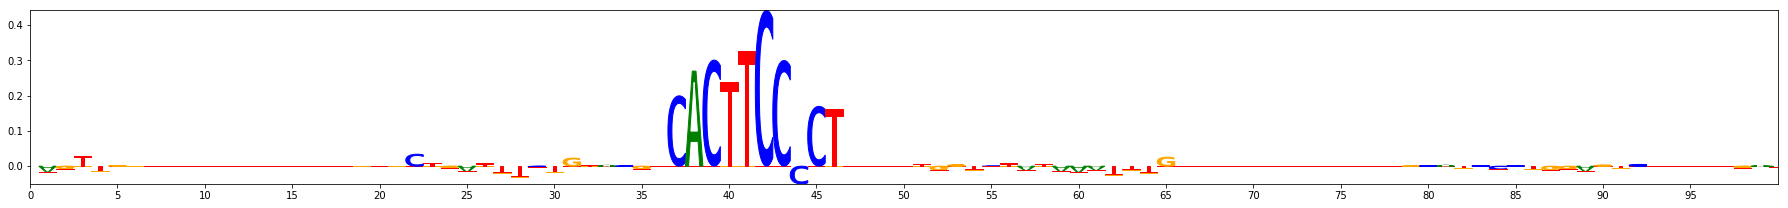

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[550:650],deep_lift_input_spi1[2].squeeze()[550:650])

If we query the sequence "CACTTCCCCT" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for SPIB: 
<img src="https://github.com/kundajelab/dragonn/blob/master/paper_supplement/tutorial_images/SPI1.Tut4.png?raw=1" alt="SPI12TomTom" width="400"/>


### Regression model 

In [0]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence (>0.9)
#get the true positive predictions 
true_pos=spi1_test_regression_truth[(spi1_test_regression_truth.values*spi1_test_regression_predictions)>2]
true_pos.shape

(16530, 1)

In [0]:
deep_lift_input=one_hot_from_bed([i for i in true_pos.index],"hg19.genome.fa.gz")
deep_lift_input.shape

(16530, 1, 1000, 4)

In [0]:
help(deeplift)

Help on function deeplift in module dragonn.tutorial_utils:

deeplift(model, X, batch_size=200, target_layer_idx=-2)
    Returns (num_task, num_samples, 1, num_bases, sequence_length) deeplift score array.



In [0]:
deep_lift_scores_spi1=deeplift(spi1_regression_model,deep_lift_input_spi1,target_layer_idx=-1)

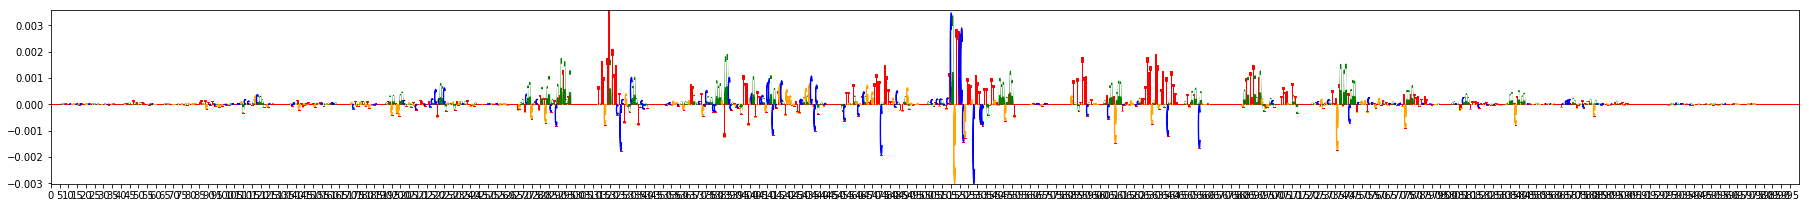

In [0]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

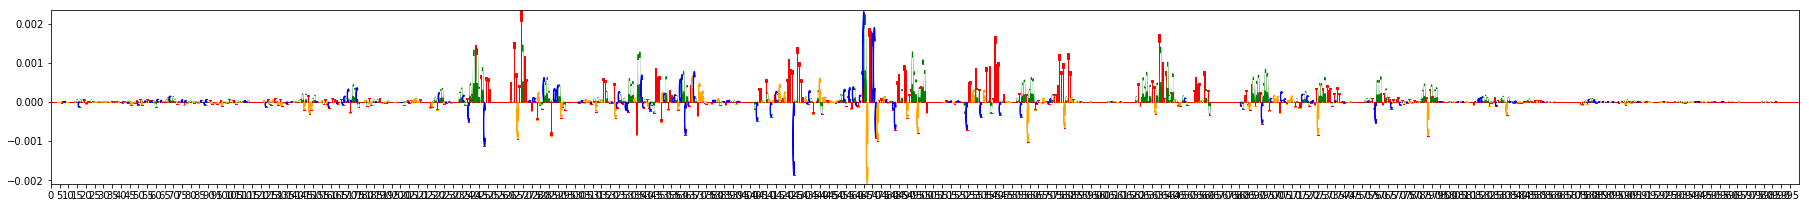

In [0]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

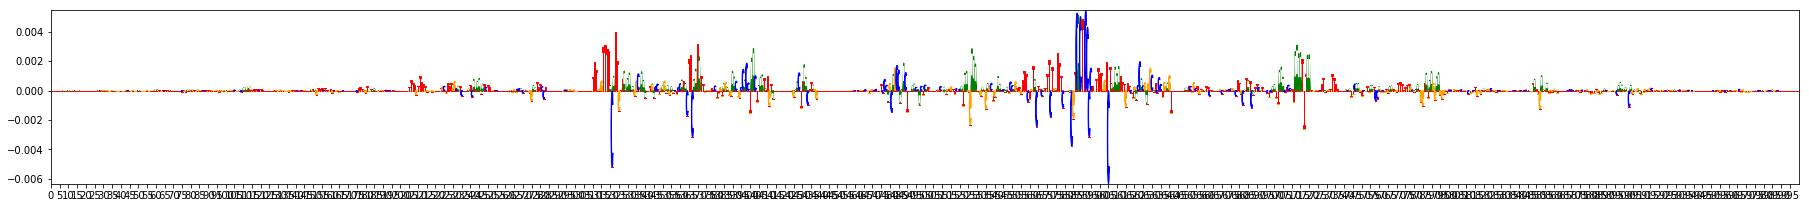

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

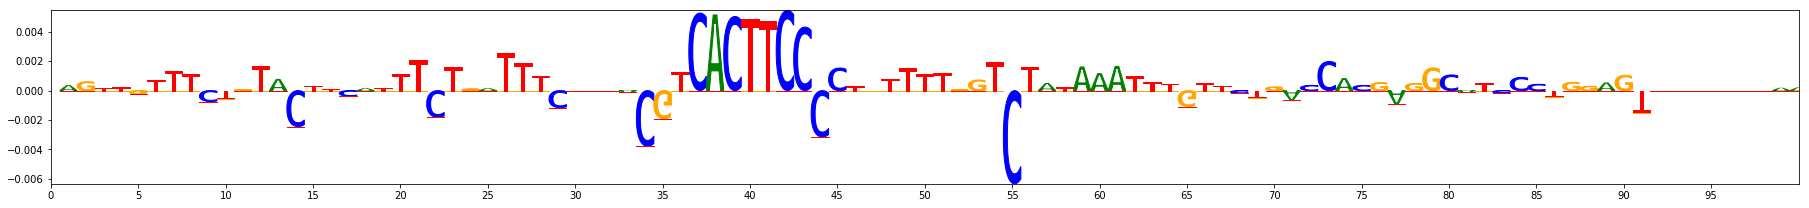

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[550:650],deep_lift_input_spi1[2].squeeze()[550:650])

The motif learned by the regression model matches the canonical SPI1 motif, though the deepLIFT tracks are noisier compared to those for the classification model. 


## Recovering bQTL effect sizes: Classification vs Regression <a name='7'>
<a href=#outline>Home</a>

In [0]:
from dragonn.generators import * 
bqtl_ref_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [0]:
bqtl_ref_classification_predictions=spi1_classification_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)

7811/7811 [==============================] - 76s 10ms/step


In [0]:
bqtl_alt_classification_predictions=spi1_classification_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_ref_classification_truth=bqtl_ref_gen.data['pvalue']

7811/7811 [==============================] - 77s 10ms/step


In [0]:
print(bqtl_ref_classification_predictions.shape)
print(bqtl_alt_classification_predictions.shape)
print(bqtl_ref_classification_truth.shape)

(999799, 1)
(999799, 1)
(999799,)


In [0]:
bqtl_ref_regression_predictions=spi1_regression_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_alt_regression_predictions=spi1_regression_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


7811/7811 [==============================] - 76s 10ms/step


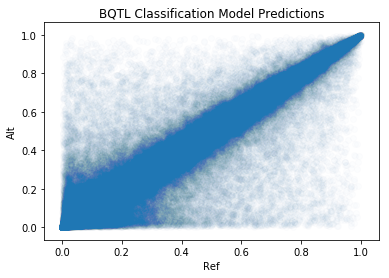

In [0]:
plt.scatter(bqtl_ref_classification_predictions, bqtl_alt_classification_predictions, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Classification Model Predictions")
plt.show()


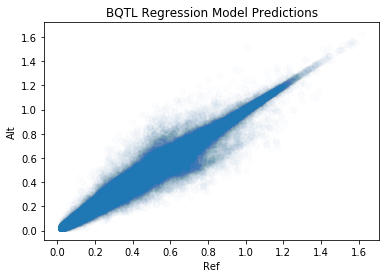

In [0]:
plt.scatter(bqtl_ref_regression_predictions, bqtl_alt_regression_predictions, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Regression Model Predictions")
plt.show()

## Model-predicted SNP effect sizes vs bQTL effect sizes <a name='8'>
<a href=#outline>Home</a>

In [0]:
logpval=np.log10(bqtl_ref_classification_truth.values)
delta=bqtl_alt_classification_predictions-bqtl_ref_classification_predictions


## Kat's Model Architecture (Classification)<a name='a'>
<a href=#outline>Home</a>

In [0]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.constraints import max_norm

def initialize_kat_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

In [0]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)


In [0]:
#Train the SPI1 classification model 
spi1_kat_classification_model=initialize_kat_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_kat_classification=spi1_kat_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 468s 47ms/step - loss: 0.1402 - sensitivity: 0.9161 - specificity: 0.9576 - fpr: 0.0424 - fnr: 0.0839 - precision: 0.9020 - f1: 0.9082 - val_loss: 0.1474 - val_sensitivity: 0.9162 - val_specificity: 0.9556 - val_fpr: 0.0444 - val_fnr: 0.0838 - val_precision: 0.8988 - val_f1: 0.9066
Epoch 2/150
10000/10000 [==============================] - 438s 44ms/step - loss: 0.0977 - sensitivity: 0.9531 - specificity: 0.9685 - fpr: 0.0315 - fnr: 0.0469 - precision: 0.9284 - f1: 0.9402 - val_loss: 0.2024 - val_sensitivity: 0.8302 - val_specificity: 0.9798 - val_fpr: 0.0202 - val_fnr: 0.1698 - val_precision: 0.9466 - val_f1: 0.8834
Epoch 3/150
10000/10000 [==============================] - 440s 44ms/step - loss: 0.0846 - sensitivity: 0.9649 - specificity: 0.9714 - fpr: 0.0286 - fnr: 0.0351 - precision: 0.9354 - f1: 0.9495 - val_loss: 0.2689 - val_sensitivity: 0.7668 - val_specificity: 0.9865 - val_fpr: 0.0135 - val_fnr: 0.2332 - val_precision

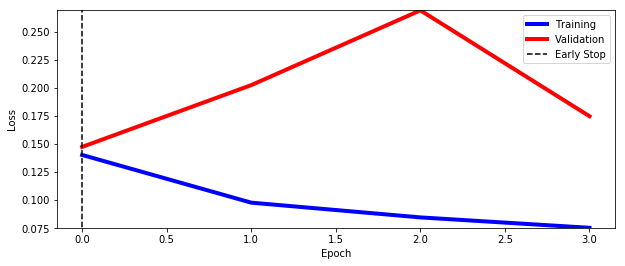

In [0]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_kat_classification)

In [0]:
from dragonn.generators import * 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_classification_predictions=spi1_kat_classification_model.predict_generator(spi1_test_classification_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_classification_truth=spi1_test_classification_gen.data

6047/6047 [==============================] - 415s 69ms/step


In [0]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_truth.values.astype(bool),spi1_test_classification_predictions))

Loss: 0.1083	Balanced Accuracy: 93.70%	 auROC: 0.985	 auPRC: 0.367
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|4.6%	 Num Positives: 20639	 Num Negatives: 6025889


## Kat's Model Architecture (Regression)<a name='b'>
<a href=#outline>Home</a>

In [0]:
def initialize_kat_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))


    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

In [0]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.01)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.01)


In [0]:
#Train the SPI1 regression model 
spi1_kat_regression_model=initialize_kat_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_kat_regression=spi1_kat_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 287s 29ms/step - loss: 0.1117 - val_loss: 0.1079
Epoch 2/150
10000/10000 [==============================] - 253s 25ms/step - loss: 0.1014 - val_loss: 0.1053
Epoch 3/150
10000/10000 [==============================] - 250s 25ms/step - loss: 0.0976 - val_loss: 0.1026
Epoch 4/150
10000/10000 [==============================] - 250s 25ms/step - loss: 0.0971 - val_loss: 0.1005
Epoch 5/150
10000/10000 [==============================] - 251s 25ms/step - loss: 0.0958 - val_loss: 0.1006
Epoch 6/150
10000/10000 [==============================] - 253s 25ms/step - loss: 0.0952 - val_loss: 0.0993
Epoch 7/150
10000/10000 [==============================] - 250s 25ms/step - loss: 0.0944 - val_loss: 0.0997
Epoch 8/150
10000/10000 [==============================] - 249s 25ms/step - loss: 0.0941 - val_loss: 0.0979
Epoch 9/150
10000/10000 [==============================] - 254s 25ms/step - loss: 0.0937 - val_loss: 0.0988
Epoch 10/150
10000/10000 [==

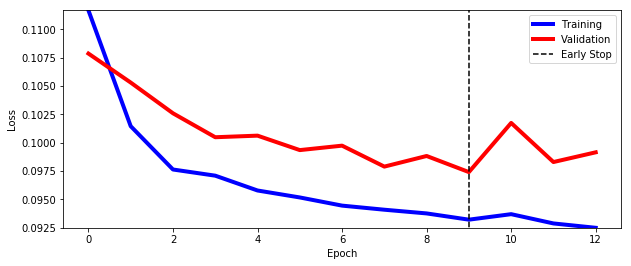

In [0]:
plot_learning_curve(history_kat_regression)

In [0]:
from dragonn.generators import * 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_kat_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 397s 66ms/step


In [0]:
## find the indices of the non-zero coverage bins 
nonzero_bins=spi1_test_regression_truth.max(axis=1)>0

In [0]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.5677105], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.5459221333990046, pvalue=0.0)


In [0]:
# Calculate the spearman and pearson correlation, restricted to non-zero bins 
corr_pearson_nonzero_bins=pearsonr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
corr_spearman_nonzero_bins=spearmanr(spi1_test_regression_truth[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
print("Pearson correlation on test set:"+str(corr_pearson_nonzero_bins))
print("Spearman correlation on test set:"+str(corr_spearman_nonzero_bins))

Pearson correlation on test set:(array([0.5163107], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.43622369943429745, pvalue=0.0)


In [0]:
test_df=pd.DataFrame({"Observed":list(spi1_test_regression_truth.values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions.squeeze())})

In [0]:
test_df_nonzero=pd.DataFrame({"Observed":list(spi1_test_regression_truth[nonzero_bins].values.squeeze()),
                     "Predicted":list(spi1_test_regression_predictions[nonzero_bins].squeeze())})

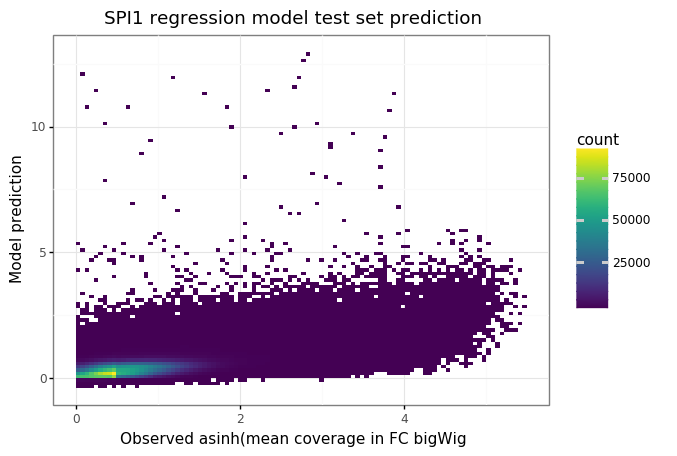

<ggplot: (-9223363281935635789)>


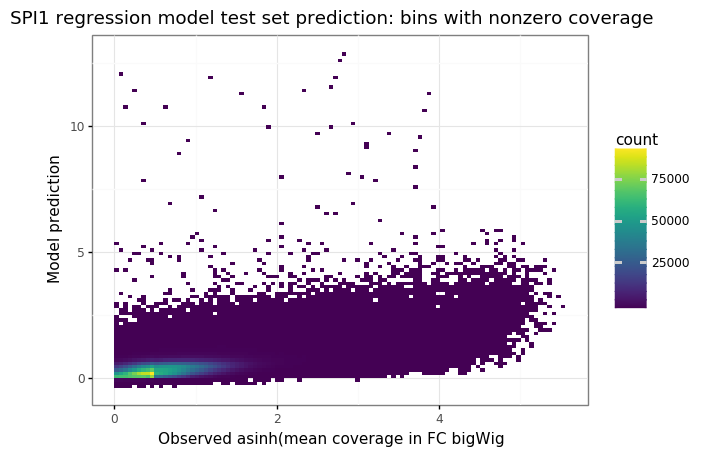

<ggplot: (-9223363281934056227)>


In [0]:
import plotnine 
from plotnine import * 
print((ggplot(test_df,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction")))

print((ggplot(test_df_nonzero,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction: bins with nonzero coverage")))

## Kat's Model DeepLIFT profiles (Classification)

In [0]:
spi1_test_classification_truth_bool=spi1_test_classification_truth.values.astype(bool)
true_pos_spi1=spi1_test_classification_truth[spi1_test_classification_truth_bool*spi1_test_classification_predictions >0.9]

In [0]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

(15408, 1, 1000, 4)

In [0]:
from dragonn.tutorial_utils import deeplift, plot_seq_importance
deep_lift_scores_spi1=deeplift(spi1_kat_classification_model,deep_lift_input_spi1)

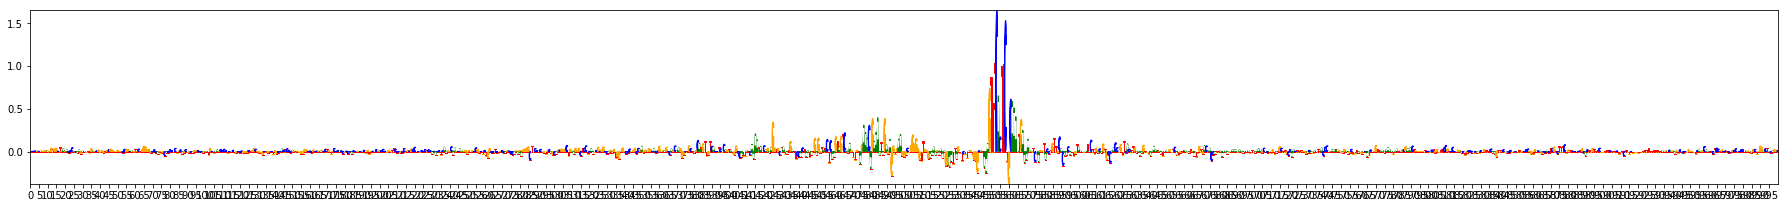

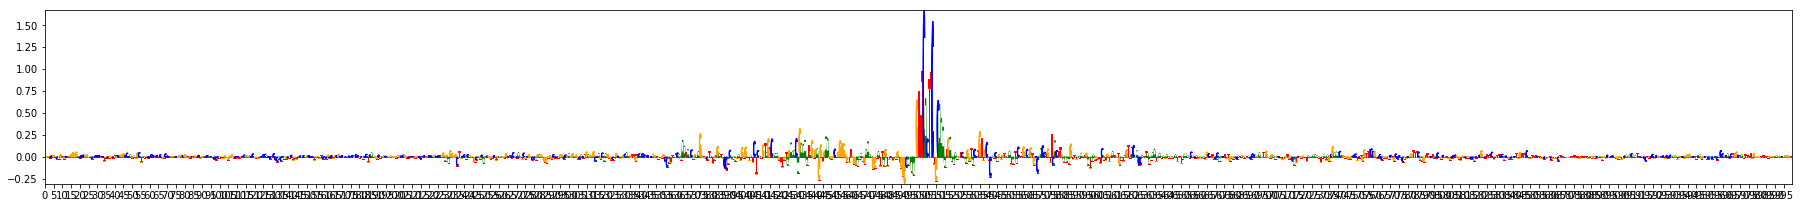

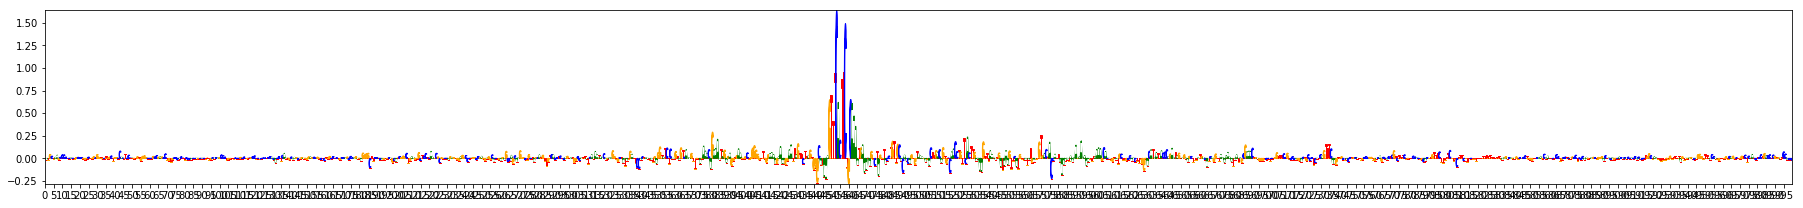

In [0]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

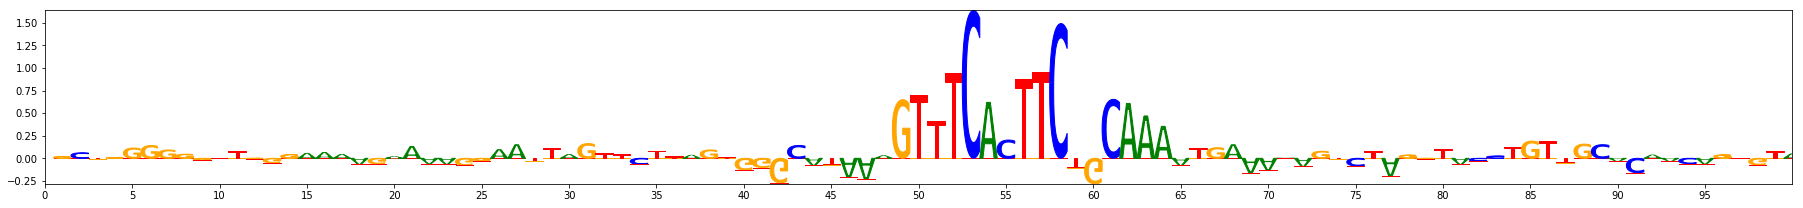

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[400:500],deep_lift_input_spi1[2].squeeze()[400:500])

If we query the sequence "GTTTCACTTCTGCAAA" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match (p=3.55e-03) for SPIB: 
<img src="https://github.com/kundajelab/dragonn/blob/master/paper_supplement/tutorial_images/SPIB.Kat.png?raw=1" alt="SPI12TomTom" width="400"/>

## Kat's Model DeepLIFT profiles (Regression)

In [0]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence (>0.9)
#get the true positive predictions 
true_pos=spi1_test_regression_truth[(spi1_test_regression_truth.values*spi1_test_regression_predictions)>4]
true_pos.shape

(15305, 1)

In [0]:
deep_lift_input=one_hot_from_bed([i for i in true_pos.index],"hg19.genome.fa.gz")
deep_lift_input.shape

(15305, 1, 1000, 4)

In [0]:
deep_lift_scores_spi1=deeplift(spi1_regression_model,deep_lift_input_spi1,target_layer_idx=-1)

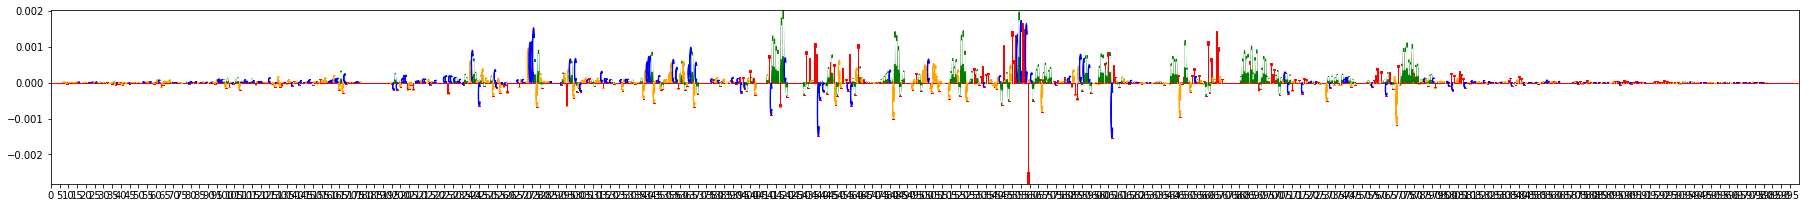

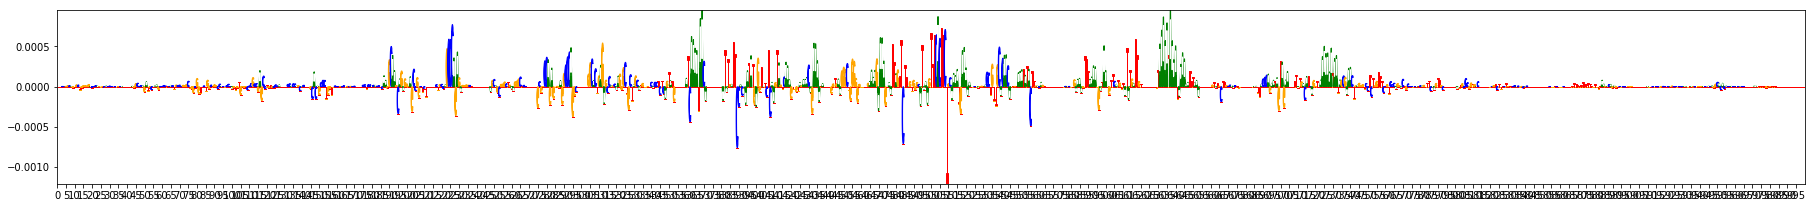

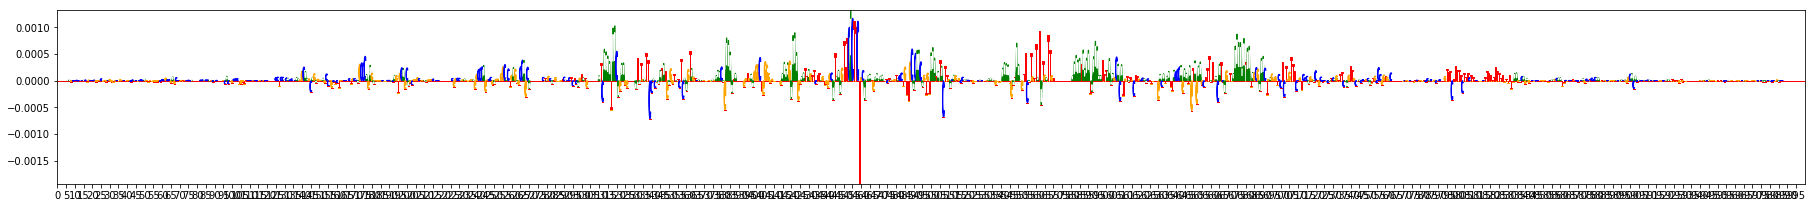

In [0]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

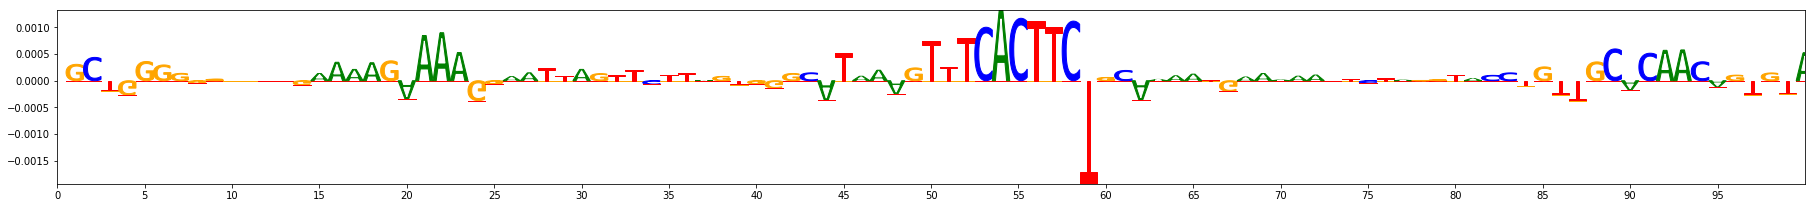

In [0]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[400:500],deep_lift_input_spi1[2].squeeze()[400:500])

## Conclusions <a name='9'>
<a href=#outline>Home</a>

## Save tutorial outputs <a name='10'>
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [0]:
#save the models 
spi1_kat_classification_model.save("SPI1.kat.classification.model.hdf5")
spi1_kat_regression_model.save("SPI1.kat.regression.model.hdf5")

#spi1_classification_model.save("SPI1.classification.model.hdf5")
#spi1_regression_model.save("SPI1.regression.model.hdf5")
#save the test predictions 
#import h5py 
#test_set_predictions=h5py.File("SPI1.test.predictions.hdf5",'w')
#test_set_predictions.create_dataset("classification",data=spi1_test_classification_predictions)
#test_set_predictions.create_dataset("regression",data=spi1_test_regression_predictions)
#test_set_predictions.close() 
